# SST-Taux feedback : 

Computes zonal wind stress anomalies (TauxA) in the western equatorial Pacific (horizontal Niño4 average) regressed onto sea surface temperature anomalies (SSTA) in the eastern equatorial Pacific (horizontal Niño3 average).

#### Reference observations:
TropFlux 1979-2018 (main)

SST: ERSSTv5 1854-2023, HadISST 1870-2023, COBE2 1850-2023, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023

Taux: ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023


## Dask Cluster 

Start a cluster with multiple cores 

In [11]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43227 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43227/status,
Dashboard: /proxy/43227/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46149,Workers: 0
Dashboard: /proxy/43227/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46111,Total threads: 1
Dashboard: /proxy/36531/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:38717,


## Comparison for ESM1.6

- Use ACCESS-MOPPeR interactive API to CMORise required variable. (May take some time)
- Write output to netCDF to read in later in other notebooks too
- or convert to iris cube to tied into recipe

Configuration for using ACCESS-MOPPeR will be created first time you use it.
it will ask for 
- Name,
- organisation
- email
- orcid

In [12]:
import glob
from access_mopper import ACCESS_ESM_CMORiser

ROOT_FOLDER = (
    "/g/data/p73/archive/CMIP7/ACCESS-ESM1-6/spinup/JuneSpinUp-JuneSpinUp-bfaa9c5b/"
)

OUTPUT_FOLDER = "/scratch/nf33/fc6164/MOPPeR"

In [13]:
parent_experiment_config = {
    "parent_experiment_id": "piControl",
    "parent_activity_id": "CMIP",
    "parent_source_id": "ACCESS-ESM1-5",
    "parent_variant_label": "r1i1p1f1",
    "parent_time_units": "days since 0001-01-01 00:00:00",
    "parent_mip_era": "CMIP6",
    "branch_time_in_child": 0.0,
    "branch_time_in_parent": 54786.0,
    "branch_method": "standard",
}

In [14]:

FILES = glob.glob(ROOT_FOLDER + "output0[0-9][0-9]/atmosphere/netCDF/*mon.nc")
len(FILES)
## reduce the years to cmorise by the output folders

1200

In [15]:
cmoriser = ACCESS_ESM_CMORiser(
    input_paths=FILES,
    compound_name="Amon.ts",
    experiment_id="piControl",
    source_id="ACCESS-ESM1-5",
    variant_label="r1i1p1f1",
    grid_label="gn",
    activity_id="CMIP",
    output_path=OUTPUT_FOLDER,
    parent_info=parent_experiment_config,  # <-- This is optional, can be skipped if not needed
)

In [16]:
cmoriser.run()

In [17]:
# cmoriser.write()
esm16_ts = cmoriser.to_iris()[0]

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/fileformats/cf.py:664: IrisCfMissingVarWarning: Missing CF-netCDF grid mapping variable 'latitude_longitude', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(


In [23]:
from esmvalcore.dataset import Dataset

In [33]:
model_ts_datasets = { 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20140101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

#tauu
model_tauu = {"ACCESS-ESM1-5": 
    model_ts_datasets["ACCESS-ESM1-5"].copy(short_name='tauu',mip="Amon")}


obs_tos_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    timerange="19790101/20181231",
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    timerange="19790101/20181231",
    tier=2),
}
obs_tauu_datasets = {
 "NCEP-DOE-R2": 
     Dataset(
     short_name='tauu',
     dataset='NCEP-DOE-R2',
     mip="Amon",
     project='OBS6',
     type='reanaly',
     timerange="19790101/20181231",
     tier=2)
}

In [25]:
for name, dataset in model_ts_datasets.items():
    dataset.add_supplementary(short_name='sftof', mip="Ofx")
    dataset.add_supplementary(short_name="areacello", mip="Ofx")
for name, dataset in model_tauu.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [ ]:
model_ts_datasets = {name: dataset.load() for name, dataset in model_ts_datasets.items()}
model_tauu = {name: dataset.load() for name, dataset in model_tauu.items()}

In [34]:
obs_tos_datasets = {name: dataset.load() for name, dataset in obs_tos_datasets.items()}
obs_tauu_datasets = {name: dataset.load() for name, dataset in obs_tauu_datasets.items()}

In [28]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np

In [29]:
def sst_east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land")
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino3_region)
    cube = area_statistics(cube,operator='mean')
    
    return cube


def taux_west(cube):
    region = {"start_longitude": 160., "end_longitude": 210., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = convert_units(cube, units="1e-3 N/m2")
    cube = mask_landsea(cube, mask_out="land")
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **region)
    cube = area_statistics(cube,operator='mean')
    return cube   

In [ ]:
model_tos_prep = {name: sst_east(dataset) for name, dataset in model_ts_datasets.items()}
model_tauu_prep = {name: taux_west(dataset) for name, dataset in model_tauu.items()}

In [35]:
obs_tos_prep = {name: sst_east(dataset) for name, dataset in obs_tos_datasets.items()}
obs_tauu_prep = {name: taux_west(dataset) for name, dataset in obs_tauu_datasets.items()}

## Calculate Linear regression

In [31]:

def linreg_1d(tauu_cube, ts_cube):
    B_data = ts_cube.data
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, tauu_cube.data, rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept


# Diagnostic Level 1

(420,) (420,)
(480,) (480,)
metric:65.0023877620697


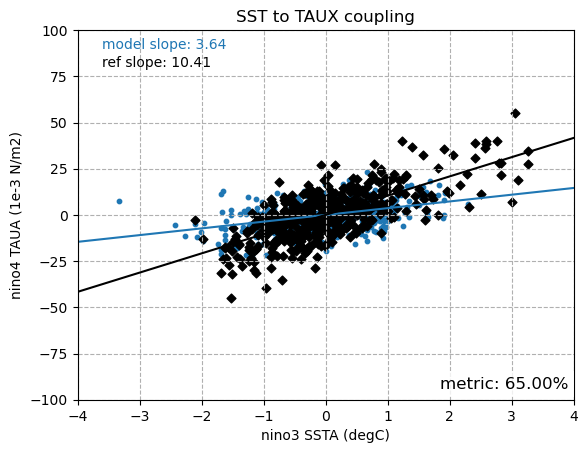

In [36]:

xseq = np.linspace(-4, 4, num=100)

# linregress(model_tauu_prep["ACCESS-ESM1-5"].data, model_tos_prep["ACCESS-ESM1-5"].data)
slope, intcpt = linreg_1d(model_tauu_prep["ACCESS-ESM1-5"], model_tos_prep["ACCESS-ESM1-5"])
plt.plot(xseq, intcpt+slope*xseq)
mod_slope = slope

slope, intcpt = linreg_1d(obs_tauu_prep["NCEP-DOE-R2"], obs_tos_prep["ERSSTv5"])
plt.plot(xseq, intcpt+slope*xseq, color='black')
metric_val = abs((mod_slope-slope)/slope)*100

print(model_tauu_prep["ACCESS-ESM1-5"].shape, model_tos_prep["ACCESS-ESM1-5"].shape) #scatter plot
yunit = model_tauu_prep["ACCESS-ESM1-5"].units 
xunit = model_tos_prep["ACCESS-ESM1-5"].units
plt.scatter(model_tos_prep["ACCESS-ESM1-5"].data, model_tauu_prep["ACCESS-ESM1-5"].data, s=10)

print(obs_tos_prep["ERSSTv5"].shape, obs_tauu_prep["NCEP-DOE-R2"].shape)
plt.scatter(obs_tos_prep["ERSSTv5"].data, obs_tauu_prep["NCEP-DOE-R2"].data,s=20, c='black', marker='D')
plt.xlim(-4,4)
plt.ylim(-100,100)

plt.title('SST to TAUX coupling')
plt.ylabel(f'nino4 TAUA ({yunit})')
plt.xlabel(f'nino3 SSTA ({xunit})')
plt.grid(linestyle='--')
## text slope
plt.text(0.05,0.95, f'model slope: {mod_slope:.2f}', color='C0',transform=plt.gca().transAxes)
plt.text(0.05,0.9, f'ref slope: {slope:.2f}', color='black',transform=plt.gca().transAxes)

plt.text(0.99, 0.03, f'metric: {metric_val:.2f}%', fontsize=12, ha='right',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
print(f'metric:{metric_val}')

Figure 1: scatterplot of sea surface temperature anomalies (SSTA) in the eastern equatorial Pacific (Niño3 averaged) and zonal wind stress anomalies (TauxA) in the western equatorial Pacific (Niño4 averaged), showing the strength of the SST-to-Taux coupling (usually too weak). The black and blue markers show respectively the reference and the model. The metric is based on the slope of the regression and is the absolute value of the relative difference: abs((model-ref)/ref)*100.

# Diagnostic Level 2

In [37]:
import pandas as pd

def linreg_df(ts, tauu):
    B_data = np.array(ts)
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, np.array(tauu), rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept

def plt_lvl2_subplot(ts_cube, tauu_cube, dataset_label):
    
    df = pd.DataFrame({'tos':ts_cube.data, 'tauu':tauu_cube.data})
    slopes = []
    print(dataset_label, 'shape: ', df.shape)
    plt.scatter(ts_cube.data, tauu_cube.data, c='k', s=10)
    xseq = np.linspace(-50, 50, num=50)
    slope, intcpt = linreg_df(df['tos'], df['tauu'])
    plt.plot(xseq, intcpt+slope*xseq, c='black')
    slopes.append(slope)
    
    xseq = np.linspace(-50, 0, num=50) #
    slope, intcpt = linreg_df(df.loc[df['tos']<0, 'tos'], df.loc[df['tos']<0, 'tauu'])
    
    plt.plot(xseq, intcpt+slope*xseq, linewidth=3)
    slopes.append(slope)
    
    xseq = np.linspace(0, 50, num=50)
    slope, intcpt = linreg_df(df.loc[df['tos']>0, 'tos'], df.loc[df['tos']>0, 'tauu'])
    plt.plot(xseq, intcpt+slope*xseq, color='red', linewidth=3)
    slopes.append(slope)

    plt.title(dataset_label)
    plt_settings(slopes)

def plt_settings(slopes):
    plt.xlim(-4,4)
    plt.xticks(np.arange(-4,5,2))
    plt.ylim(-100,100)
    plt.yticks(np.arange(-100,120,50))
    plt.grid(linestyle='--')
    plt.ylabel(f'nino4 TAUXA (1e-3 N/m2)')
    plt.xlabel(f'nino3 SSTA (°C)') #
    print(slopes)
    plt.text(0.02, 0.85, f'slope(all): {slopes[0]:.2f}\nslope(x<0): {slopes[1]:.2f}\nslope(x>0): {slopes[2]:.2f}', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ACCESS-ESM1-5 shape:  (420, 2)
[3.6433907, 4.169258, 3.620789]
ERSSTv5_NCEP-DOE-R2 shape:  (480, 2)
[10.410398, 11.4895735, 10.170975]


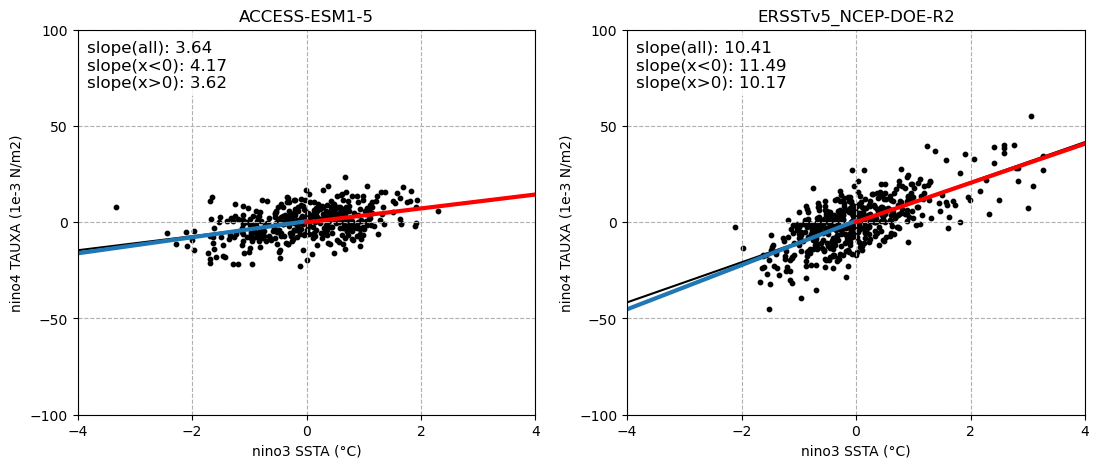

In [39]:
## plot figures
fig = plt.figure(figsize=(13, 5))
ax = plt.subplot(121)

plt_lvl2_subplot(model_tos_prep["ACCESS-ESM1-5"], model_tauu_prep["ACCESS-ESM1-5"], 'ACCESS-ESM1-5')

ax = plt.subplot(122)
plt_lvl2_subplot(obs_tos_prep["ERSSTv5"], obs_tauu_prep["NCEP-DOE-R2"], 'ERSSTv5_NCEP-DOE-R2')

Figure 2: scatterplot of sea surface temperature anomalies (SSTA) in the eastern equatorial Pacific (Niño3 averaged) and zonal wind stress anomalies (TauxA) in the western equatorial Pacific (Niño4 averaged), showing the possible nonlinearity in the strength of the SST-to-Taux coupling (usually shows no nonlinearity in both reference and model). The black, red and blue lines and numbers show respectively linear regression computed for all SSTA, SSTA>0 and SSTA<0, the left and right scatterplots show respectively the reference and the model.

## Dive down level 3
The third level shows the remote coupling in the equatorial Pacific.

In [40]:
#level 3 zonal runningaverage
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import mask_above_threshold, mask_below_threshold

def sst_east_3(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land")
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino3_region)
    cube = area_statistics(cube,operator='mean')    
    return cube

def taux_eqp(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="1e-3 N/m2")
    cube = mask_landsea(cube, mask_out="land") 
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **region)
    cube = meridional_statistics(cube,operator='mean')
    cube = rolling_window_statistics(cube, coordinate='longitude',operator='mean',window_length=30)
    return cube 


In [41]:
model_tos_prep = {name: sst_east_3(dataset) for name, dataset in model_ts_datasets.items()}
model_tauu_prep = {name: taux_eqp(dataset) for name, dataset in model_tauu.items()}

AttributeError: 'Dataset' object has no attribute 'convert_units'

In [42]:
obs_tos_prep = {name: sst_east_3(dataset) for name, dataset in obs_tos_datasets.items()}
obs_tauu_prep = {name: taux_eqp(dataset) for name, dataset in obs_tauu_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/cube.py:4343: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/cube.py:4898: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(


In [43]:
def lin_regress_matrix(cubeA, cubeBsst):
    
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    if cubeA.shape[0] == cubeBsst.shape[0]:
        B_data = cubeBsst.data.flatten() # or all
    else:
        B_data = cubeBsst.data.compressed() # masked threshold cube (time,) 

    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    
    print('least squares data shapes ',B_with_intercept.shape, A_data.shape)
    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)

    # Create a new Iris Cube for the regression results
    result_cube = iris.cube.Cube(coefs[0], long_name='regression SSTA,TAUXA',
                                 dim_coords_and_dims=[(cubeA.coord('longitude'), 0)])

    return result_cube


def feedback_nonlin(sst_cube, tauu_cube):
    tauu_aux = tauu_cube.copy()
    sst_coord = iris.coords.AuxCoord(sst_cube.data, sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)
    tauu_aux.add_aux_coord(sst_coord, 0)

    below0 = iris.Constraint(sea_surface_temperature=lambda cell: cell < 0)
    above0 = iris.Constraint(sea_surface_temperature=lambda cell: cell > 0)
    ssta_neg = mask_above_threshold(sst_cube.copy(), 0) #x<0
    ssta_pos = mask_below_threshold(sst_cube.copy(), 0) #x>0
    xbelow0 = tauu_aux.extract(below0)
    xabove0 = tauu_aux.extract(above0)
    
    outreg_cube = lin_regress_matrix(xbelow0, ssta_neg)
    posreg_cube = lin_regress_matrix(xabove0, ssta_pos)

    return outreg_cube, posreg_cube

least squares data shapes  (196, 2) (196, 1)
least squares data shapes  (224, 2) (224, 1)
least squares data shapes  (272, 2) (272, 36)
least squares data shapes  (208, 2) (208, 36)
least squares data shapes  (420, 2) (420, 1)
least squares data shapes  (480, 2) (480, 36)


Text(0.5, 1.0, 'Wind stress feedback')

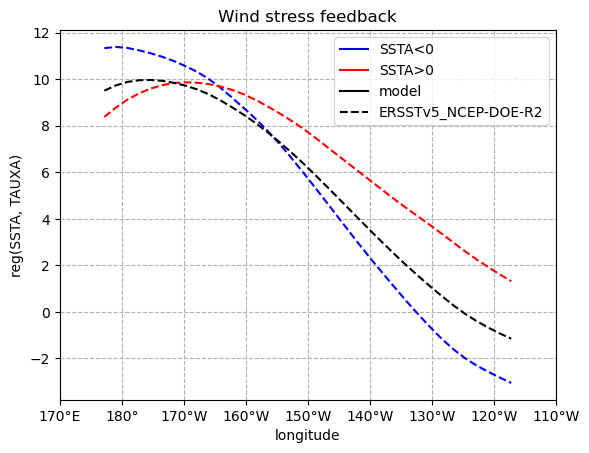

In [44]:
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

neg, pos = feedback_nonlin(model_tos_prep["ACCESS-ESM1-5"], model_tauu_prep["ACCESS-ESM1-5"])

qplt.plot(neg, color='blue', linestyle='solid', label='SSTA<0')
qplt.plot(pos, color='red', linestyle='solid', label='SSTA>0')

neg, pos = feedback_nonlin(obs_tos_prep["ERSSTv5"], obs_tauu_prep["NCEP-DOE-R2"])
qplt.plot(neg, color='blue', linestyle='--')
qplt.plot(pos, color='red', linestyle='--')


cb = lin_regress_matrix(model_tauu_prep["ACCESS-ESM1-5"],model_tos_prep["ACCESS-ESM1-5"])
        
qplt.plot(cb, color='black', linestyle='solid', label='model')

cb2 = lin_regress_matrix(obs_tauu_prep["NCEP-DOE-R2"], obs_tos_prep["ERSSTv5"])
qplt.plot(cb2, color='black', linestyle='--', label='ERSSTv5_NCEP-DOE-R2')

plt.xlim(170, 250) 
plt.xlabel('longitude')
plt.ylabel('reg(SSTA, TAUXA)')
plt.grid(linestyle='--')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))
plt.legend()
plt.title('Wind stress feedback')

Figure 3: spatial structure of zonal wind stress anomalies (TauxA) in the equatorial Pacific (meridional 5°S-5°N average; zonal 30° running average) regressed onto sea surface temperature anomalies (SSTA) in the eastern equatorial Pacific (Niño3 averaged), showing the possible nonlinearity in the strength of the SST-to-Taux coupling (the reference shows the maximum coupling around the dateline, west of the dateline for SSTA<0, east of the dateline for SSTA>0, but the amplitude of the maximum coupling is about the same; usually the models do not reproduce the displacement of the maximum coupling for all SSTA, SSTA<0, SSTA>0 and simulate a weakening of the coupling for SSTA<0). The black, red and blue lines and numbers show respectively linear regression computed for all SSTA, SSTA>0 and SSTA<0, the dashed and solid curves show respectively the reference and the model.

## Dive down level 4:

In [30]:
from esmvalcore.preprocessor import climate_statistics, extract_month
import iris.plot as iplt

def feedback_nonlin_lvl4(sst_cube, tauu_cube):
    tauu_aux = tauu_cube.copy()
    sst_coord = iris.coords.AuxCoord(sst_cube.data, sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)
    tauu_aux.add_aux_coord(sst_coord, 0)
    # print(sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)

    below0 = iris.Constraint(coord_values={sst_cube.standard_name:lambda cell: cell < 0})
    above0 = iris.Constraint(coord_values={sst_cube.standard_name:lambda cell: cell > 0})
    ssta_neg = mask_above_threshold(sst_cube.copy(), 0) #x<0
    ssta_pos = mask_below_threshold(sst_cube.copy(), 0) #x>0
    xbelow0 = tauu_aux.extract(below0)
    xabove0 = tauu_aux.extract(above0)
    
    outreg_cube = annual_structure_reg(xbelow0, ssta_neg)
    posreg_cube = annual_structure_reg(xabove0, ssta_pos)
    all_cube = annual_structure_reg(tauu_cube, sst_cube)

    return all_cube, posreg_cube, outreg_cube

def lin_regress_4(cubeA, cubeBsst):
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    if cubeA.shape[0] == cubeBsst.shape[0]:
        B_data = cubeBsst.data.flatten() # or all
    else:
        B_data = cubeBsst.data.compressed() # compress masked

    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T

    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)
    return coefs[0]
    
def annual_structure_reg(nhf_cube, ts_cube):
    months_reg = []
    for i in range(1,13):
        #extract for both cubes
        nhf = extract_month(nhf_cube, month=i)
        ts = extract_month(ts_cube, month=i)
        coefs = lin_regress_4(nhf, ts)
        # collect array for months
        months_reg.append(coefs)

    # get month_number coordinate from an existing cube
    m_cube = climate_statistics(ts_cube, operator='max', period='month')
    
    #create cube, x = months, y = lon
    result_cube = iris.cube.Cube(np.array(months_reg), long_name='regression',
                                 dim_coords_and_dims=[(nhf.coord('longitude'), 1), (m_cube.coord('month_number'), 0)])
    return result_cube  

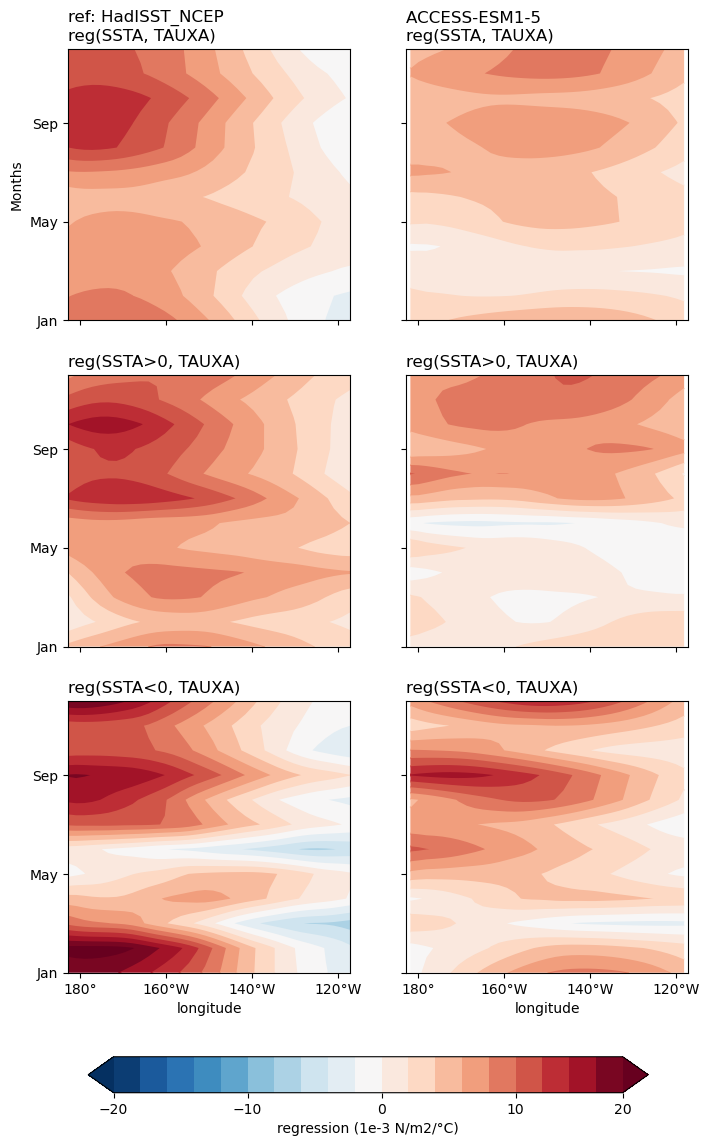

In [31]:
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

modells = feedback_nonlin_lvl4(model_tos_prep["ACCESS-ESM1-5"], model_tauu_prep["ACCESS-ESM1-5"])
obsls = feedback_nonlin_lvl4(obs_tos_prep["HadISST"], obs_tauu_prep["NCEP-DOE-R2"])
sub = ['', '>0', '<0',] #all_cube, posreg_cube, outreg_cube

fig = plt.figure(figsize=(8, 12))
i = 321
ax1 = plt.subplot(i)

for isub, cbls in enumerate(zip(obsls, modells)):
    # build ls 

    for cb in cbls:
        if i == 321:
            ax1.set_yticks(range(1, 13, 4))
            ax1.set_yticklabels(['Jan', 'May', 'Sep'] )
            ax1.set_ylabel('Months')
            ax1.set_title('ref: HadISST_NCEP \nreg(SSTA, TAUXA)', loc='left')
        else:
            ax2 = plt.subplot(i, sharex=ax1, sharey=ax1)
            ax2.set_title(f'reg(SSTA{sub[isub]}, TAUXA)', loc='left')
            if i == 322:
                ax2.set_title('ACCESS-ESM1-5 \nreg(SSTA, TAUXA)', loc='left')


        ## contour plt data
        cf1 = iplt.contourf(cb, coords=['longitude','month_number'], levels=np.arange(-20, 20, 2), extend='both', cmap="RdBu_r")
        
        if i < 325:
            plt.tick_params('x', labelbottom=False)
        else:
            plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude)) #apply to bottom left =>325
            ax2.set_xlabel("longitude")
        
        if i%2 == 0:
            plt.tick_params(labelleft=False)
        
        i += 1


cax = plt.axes([0.15,0.01,0.7,0.03])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-20, 21, 10))
cbar.set_label('regression (1e-3 N/m2/°C)')

Figure 4: spatio-mean annual structure of zonal wind stress anomalies (TauxA) in the equatorial Pacific (meridional 5°S-5°N average; zonal 30° running average) regressed onto sea surface temperature anomalies (SSTA) in the eastern equatorial Pacific (Niño3 averaged), showing the possible nonlinearity in the strength of the SST-to-Taux coupling (usually shows too weak, particularly during boreal autumn and winter coupling, the reference indicates that the coupling stops in boreal spring when SSTA<0 but not when SSTA>0, while the models usually simulate a stop of the coupling in both case). The first, second and third rows show respectively linear regression computed for all SSTA, SSTA>0 and SSTA<0, the left and right Hovmöllers show respectively the reference and the model.

In [10]:
client.close()